In [91]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from PIL import Image
import os.path
import datetime

# Keras
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, PReLU
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# Image preview
import matplotlib.pyplot as plt
% matplotlib inline

# Numpy print full array
np.set_printoptions(threshold=np.inf)

# Constants
DIRECTORY = "ml-2018spring-hw3/"
MODEL_DIRECTORY = "model/"
LABEL_MAP = {0:'生氣', 1:'厭惡', 2:'恐懼', 3:'高興', 4:'難過', 5:'驚訝', 6:'中立'}
# Parameters

In [92]:
# Functions
def get_training_data(horizontal_flip=False, shuffle_data=False, validation_split=0.0):
    filename = "train.csv"
    filepath = DIRECTORY + filename

    if os.path.exists(filepath):
        data = pd.read_csv(filepath)
        x_raw = data["feature"]
        y_raw = data["label"]
        
        
        #  Split features into array & reshape to (48, 48, 1)
        x = x_raw.str.split(expand=True).values.reshape(-1, 48, 48, 1).astype('int')
        # One hot encoding
        y = np_utils.to_categorical(y_raw)
        # Add fliplr image to label 1
        if horizontal_flip:
            (x, y) = add_fliplr_image(x, y, y_raw, 1)
        if shuffle_data:
            (x, y) = shuffle(x, y)
        
        # Split validation set
        if validation_split > 0.0 and validation_split <= 1.0:
            valid_size = int(validation_split*len(x))
            x_train = x[:-valid_size]
            x_valid = x[-valid_size:]
            y_train = y[:-valid_size]
            y_valid = y[-valid_size:]
        else:
            x_train = x
            y_train = y
            x_valid = []
            y_valid = []
    else:
        print("Error: No such file at %s" % filepath)

    return (x_train, y_train), (x_valid, y_valid), (x_raw, y_raw)
   
def get_testing_data():
    filename = "test.csv"
    filepath = DIRECTORY + filename

    if os.path.exists(filepath):
        data = pd.read_csv(filepath)
        x_test = data["feature"].str.split(expand=True).values.reshape(-1, 48, 48, 1).astype('int')
        return x_test
        
def output_prediction(y_test, filename="output.csv"):
    arr = [[i, int(y_test[i])] for i in range(len(y_test))]
    dw = pd.DataFrame(arr, columns = ["id", "label"])
    dw.to_csv(filename, index=False)

def normalize(x_set, norm_column=[]):
    x_all = np.concatenate(x_set, axis=0)
    mean = np.mean(x_all, axis=0)
    std = np.std(x_all, axis=0)
    
    for x in x_set:
        for column in norm_column:
            x[:, column] = np.subtract(x[:, column], mean[column])
            x[:, column] = np.true_divide(x[:, column], std[column])
            
    return x_set

def add_fliplr_image(x_train, y_train, y_raw, label):
    index = y_raw[y_raw == label].index
    category = np_utils.to_categorical([label], 7)
    total_categories = np.repeat(category, len(index), axis=0)
    total_images = np.empty((0, 48, 48, 1), int)

    for i in index:
        image = np.fliplr(x_train[i]).reshape(1, 48, 48, 1)
        total_images = np.append(total_images, image, axis=0)

    x_train = np.concatenate((x_train, total_images), axis=0)
    y_train = np.concatenate((y_train, total_categories), axis=0)
    return (x_train, y_train)

def shuffle(x_train, y_train):
    seed = np.arange(x_train.shape[0])
    np.random.shuffle(seed)
    x_train = x_train[seed]
    y_train = y_train[seed]
    return (x_train, y_train)

In [93]:
# Plot
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel("train")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="center right")
    plt.show()

In [218]:
(x_train, y_train), (x_valid, y_valid), (x_raw, y_raw) = get_training_data(
    horizontal_flip=True,
    shuffle_data=True,
    validation_split=0.1)

x_test = get_testing_data()

In [219]:
# Transform to 0 to 1
x_train = x_train / 255
x_test = x_test / 255
if len(x_valid) > 0:
    x_valid = x_valid / 255

In [220]:
# Normalization
if len(x_valid) > 0:
    x_total = np.concatenate((x_train, x_valid, x_test))
else:
    x_total = np.concatenate((x_train, x_test))
mean = np.mean(x_total)
std = np.std(x_total)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
if len(x_valid) > 0:
    x_valid = (x_valid - mean) / std

In [ ]:
# Image generator for data augmentation
train_gen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_gen.fit(x_train)

高興


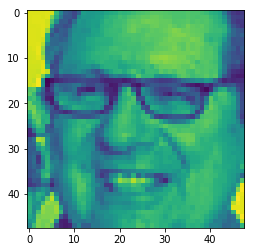

In [206]:
index = 28
print(LABEL_MAP[np.argmax(y_train[index])])
plt.imshow(x_train[index].reshape(48, 48))
plt.show()

In [237]:
# 
model = Sequential()

# CNN
# input shape (1, 48, 48)
# model.add(Conv2D(64, (3, 3), input_shape=(48, 48, 1), kernel_initializer="glorot_normal"))
# model.add(PReLU())
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), kernel_initializer="glorot_normal"))
# model.add(PReLU())
# model.add(Conv2D(128, (3, 3), kernel_initializer="glorot_normal"))
# model.add(PReLU())
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())

model.add(Conv2D(64, 5, input_shape=(48, 48, 1), kernel_initializer="glorot_normal", activation="relu"))
# model.add(PReLU())
model.add(MaxPooling2D(5, strides=2))
model.add(Conv2D(64, 3, kernel_initializer="glorot_normal", activation="relu"))
# model.add(PReLU())
model.add(Conv2D(64, 3, kernel_initializer="glorot_normal", activation="relu"))
# model.add(PReLU())
model.add(MaxPooling2D(3, strides=2))
model.add(Conv2D(128, 3, kernel_initializer="glorot_normal", activation="relu"))
# model.add(PReLU())
model.add(Conv2D(128, 3, kernel_initializer="glorot_normal", activation="relu"))
# model.add(PReLU())
model.add(MaxPooling2D(3, strides=2))
model.add(Flatten())

# DNN
model.add(Dense(units=1024, kernel_initializer="glorot_normal", activation="relu"))
# model.add(Dense(units=128, activation="relu",
#                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=512, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=7,activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 18, 18, 64)        36928     
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 5, 5, 128)         73856     
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 3, 3, 128)         147584    
__________

In [ ]:
# Load model
model_name = MODEL_DIRECTORY + "cnn.h5"
model = load_model(model_name)

In [238]:
# Checkpoint
checkpoint_name = MODEL_DIRECTORY + "checkpoint" + datetime.datetime.now().strftime("%Y%m%d%H%M%S") + ".h5" 
checkpoint = ModelCheckpoint(checkpoint_name, monitor="val_acc", verbose=1, save_best_only=True, mode="max")

In [239]:
# Training
epochs = 20
batch_size = 128
steps_per_epoch = int((x_train.shape[0]*5)/batch_size)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
train_history2 = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=epochs, callbacks=[checkpoint])
# train_history = model.fit_generator(
#     train_gen.flow(x_train, y_train, batch_size=batch_size),
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     validation_data=(x_valid, y_valid),
#     callbacks=[checkpoint])

Train on 26231 samples, validate on 2914 samples
Epoch 1/20
26231/26231 [==============================] - 106s - loss: 1.7789 - acc: 0.2727 - val_loss: 1.6364 - val_acc: 0.3445
Epoch 2/20
26231/26231 [==============================] - 105s - loss: 1.5167 - acc: 0.4096 - val_loss: 1.4300 - val_acc: 0.4389
Epoch 3/20
26231/26231 [==============================] - 105s - loss: 1.3736 - acc: 0.4729 - val_loss: 1.3266 - val_acc: 0.4866
Epoch 4/20
26231/26231 [==============================] - 105s - loss: 1.2842 - acc: 0.5076 - val_loss: 1.3240 - val_acc: 0.4990
Epoch 5/20
26231/26231 [==============================] - 105s - loss: 1.2224 - acc: 0.5370 - val_loss: 1.2551 - val_acc: 0.5182
Epoch 6/20
26231/26231 [==============================] - 105s - loss: 1.1714 - acc: 0.5557 - val_loss: 1.2515 - val_acc: 0.5271
Epoch 7/20
26231/26231 [==============================] - 105s - loss: 1.1172 - acc: 0.5783 - val_loss: 1.2091 - val_acc: 0.5439
Epoch 8/20
26231/26231 [========================

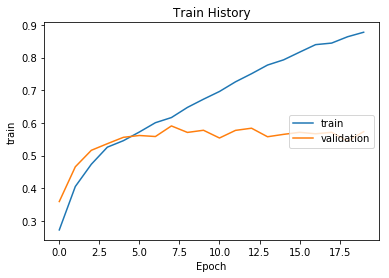

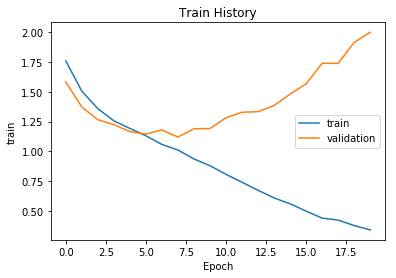

In [240]:
# Training history
show_train_history(train_history, 'acc', 'val_acc')
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
# Load checkpoint model
model = load_model(checkpoint_name)

In [241]:
model.evaluate(x_valid, y_valid)

2912/2914 [============================>.] - ETA: 0s

[1.6499171212837151, 0.559025394646534]

In [ ]:
# Confusion matrix
prediction = model.predict_classes(x_train)
print(y_valid.shape)
y_categories = np.argmax(y_train, axis=1)
pd.crosstab(y_categories, prediction, rownames=["label"], colnames=["predict"])

22880/26231 [=========================>....] - ETA: 4s

In [118]:
prob = model.predict(x_test)
y_test = np.argmax(prob, axis=1)

中立


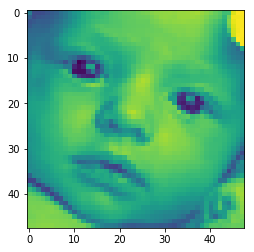

In [236]:
index = 95
print(LABEL_MAP[y_test[index]])
plt.imshow(x_test[index].reshape(48, 48))
plt.show()

In [ ]:
output_prediction(y_test, "cnn.csv")